# Obtaining LPC (Linear Prediction Coefficients) for speech command

In [5]:
import wave
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import read


%matplotlib inline

## Première Étape

### Plot préliminaire

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """


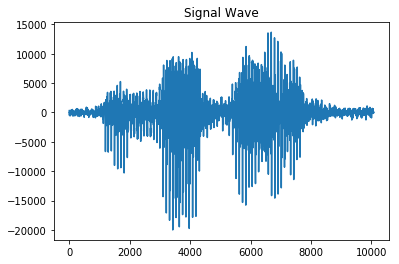

In [56]:
spf = wave.open('test3/enavant.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')


#If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

plt.figure(1)
plt.title('Signal Wave')
plt.plot(signal)
plt.show()

### Fichier Wave avec la librairie standard (voir plutot partie avec scipy)

In [6]:
signal_wave = wave.open("test3/enavant.wav")

On veut découper notre signal en trames de quelques dizaines de millisecondes.

In [7]:
(nchannels, sampwidth, framerate, nframes, comptype, compname) = signal_wave.getparams()

print(framerate)

16000


On va prendre des trames de 30 millisecondes, on veut donc des trames de (0.030 * 16000 = 480) bytes.

In [8]:
nbytes = 480
ntrames = nframes/nbytes
print(ntrames)

20.9875


In [33]:
def get_trames(signal, nbytes=480):
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = signal.getparams()
    trames = []
    signal.rewind()
    while signal.tell() != nframes:
        trame = signal.readframes(nbytes)
        trames.append(trame)
    return trames

trames = get_trames(signal=signal_wave, nbytes=nbytes)

On a fini la première étape, on a décomposé notre signal en 21 trames de quelques dizaines de millisecondes.

Les 20 premières font 30 millisecondes, et la dernière est un peu plus courte.

### Utilisation de Scipy

Evaluation toutes les 10ms avec une fenêtre de 30ms

In [50]:
[fs, a] = read("test3/stop.wav")
sig_in = np.array(a)

nbytes_fen = fs * 0.03
nbytes_pas = fs * 0.01

N = len(sig_in)/nbytes_pas

signals = []

for i in np.arange(0, len(sig_in), 10, dtype=int):
    signals.append(sig_in[i:i+30])

### Obtenir les coefficients à l' aide des signaux

Phi function (estimateur de la fonction d'autocorrélation du signal)

In [4]:
def phi(signal, k_ind):
    # phi est un estimateur de la fonction d'autocorrélation du signal
    N = len(signal)
    somme = 0
    for i in range(0, N - k_ind - 1):
        somme += signal(i) * signal(i + k_ind)
    return somme/N
    

Algorithme pour un signal

In [7]:
def params_signal(signal, K):

    alpha = []
    k = []
    # a est un tableau de tableau (taille croissante)
    a = []

    alpha.append(phi(signal, 0))
    k.append(-phi(signal, 1) / phi(signal, 0))
    a.append([-k[0]])

    for n in range(2, K):
        alpha_val = alpha[n-1] * (1 - k[n-1]^2)
        alpha.append(alpha_val)
        sum_int = 0
        for p in range(1, n):
            sum_int += a[n-1][p] * phi(n - p)
        int_val = (phi(signal, n) - sum_int)
        k.append((-1/alpha_val) * int_val)
        a_array = []
        for q in range(1, n):
            int_a_val = a[n-1][q] + k[n] * a[n-1][n-q]
            a_array.append(int_a_val)
        a_array.append( -k[n])
        a.append(a_array)
        
    return (alpha, k, a)

In [ ]:
K = 5

alpha_arr = []
k_arr = []
a_arr = []

# Il faut boucler sur tous les échantillons de notre son (rappel, on a pris des fenêtres de 30ms)
for i in range(0, len(signals)):
    [alpha, k, a] = params_signal(signals[i], K)
    alpha_arr.append(alpha)
    k_arr.append(k)
    a_arr.append(a)


### En Numpy

In [12]:
[fs, a] = read("test3/stop.wav")
signal_avant = np.array(a,dtype=float)
print(signal_avant)

[ 163.  132.  137. ...,  -56.  -21.  -34.]


In [8]:
f, t, Zxx = signal.stft(x = signal_avant, fs=fs, nperseg=320, window='hamming')

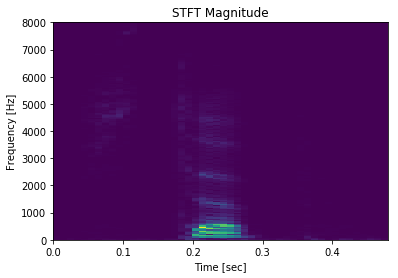

In [100]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [108]:
folder = "test3/"
files = ["enavant.wav", "enavant2.wav", "enavant3.wav", "adroite.wav", "adroite2.wav", "adroite3.wav", "agauche.wav", "agauche2.wav", "agauche3.wav", "stop.wav", "stop2.wav", "stop3.wav"]
file = "stop.wav"

In [120]:
def add_fft(folder, file, nperseg, noverlap):
    [fs, a] = read(folder + file)
    sig = np.array(a,dtype=float)
    f, t, Zxx = signal.stft(x = sig, fs=fs, noverlap=noverlap, nperseg=nperseg)
    fft_signal = {
        "frequencies": f,
        "times": t,
        "stft": Zxx
    }
    if "avant" in file:
        fft_signal["class"] = "avant"
    elif "droite" in file:
        fft_signal["class"] = "droite"
    elif "gauche" in file:
        fft_signal["class"] = "gauche"
    elif "stop" in file:
        fft_signal["class"] = "stop"
    return fft_signal

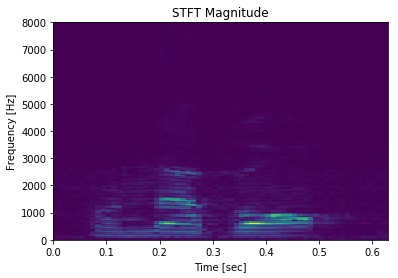

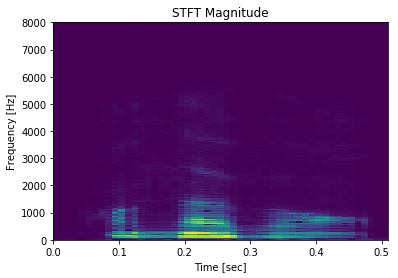

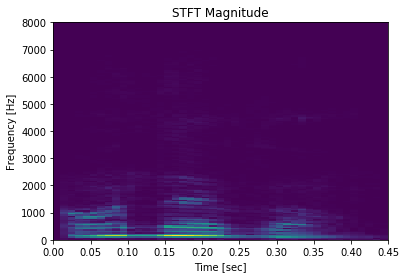

In [121]:
signals = []
for file_ in files:
    signal_ = add_fft(folder=folder, file=file_, nperseg=320, noverlap=160)
    signals.append(signal_)
    if signal_.get('class') == 'avant':
        plt.pcolormesh(signal_.get('times'), signal_.get('frequencies'), np.abs(signal_.get('stft')), vmin=0)
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

In [131]:
signals[0].get("stft")

array([[ -3.07852396e+01 +0.00000000e+00j,
         -2.48266857e+01 +0.00000000e+00j,
          6.05605761e+00 +0.00000000e+00j, ...,
         -1.72569440e+01 +0.00000000e+00j,
          5.65944990e+01 +0.00000000e+00j,
          3.86482293e+01 +0.00000000e+00j],
       [  3.83061141e+01 -6.29816411e+00j,
          6.16060994e+01 +5.09443647e+00j,
          4.36923549e+01 -1.82391237e+01j, ...,
          1.56701286e+01 -2.30977719e+01j,
         -6.45257101e+01 -9.41316657e+01j,
         -5.80376213e+01 -1.71600963e+01j],
       [ -3.62345999e+01 +3.30081100e+01j,
         -9.31114216e+01 +3.37479835e+01j,
         -9.88950889e+01 +1.40487638e+01j, ...,
          5.86777560e+01 +9.47877957e+01j,
          4.39197145e+01 +1.22167333e+02j,
          3.10250660e+01 +8.44779973e+01j],
       ..., 
       [  4.12378008e-01 +7.60145377e-01j,
          1.03297866e+00 -3.44174324e-01j,
         -8.37689125e-01 -1.23644852e+00j, ...,
         -1.45600583e+00 +4.88162570e-01j,
         -5.698657

In [129]:
fmin = min(signals[0].get("frequencies"))
fmin = 2595 * math.log10( 1 + fmin / 700)
fmax = max(signals[0].get("frequencies"))
fmax = 2595 * math.log10( 1 + fmax / 700)
nf = len(signals[0].get("frequencies"))
w = 2*(fmax - fmin) / (nf + 1)